In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

### Cargamos el dataset

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df['Pclass'] = df.Pclass.astype(object)

Eliminamos las columnas que no son predicturas

In [4]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Creamos cageogoricas

In [5]:
df = pd.get_dummies(df, drop_first=True)

In [6]:
df['Age'] = df['Age'].fillna(df.Age.mean())
target = 'Survived'

### Crea una regresion logistica

In [7]:
X = df.drop(target, axis=1)
y = df[target]

model = linear_model.LogisticRegression().fit(X, y)
probabilidades = model.predict_proba(X)

p1 = [i[1] for i in probabilidades]

### Concepto odds

Mi equipo gana 1 a 4


In [8]:
1/4

0.25

Probabilidad de ganar 

In [9]:
1/(1+4)

0.2

Probabilidad perder

In [10]:
1 - (1/(1+4))

0.8

Mi equipo gana 5 a 3

In [11]:
5/3

1.6666666666666667

Probabilidad que equipo gane 

In [12]:
5/(5+3)

0.625

Probabilidd de perder

In [13]:
1 - (5/(5+3))

0.375

¿Qué pasa si divido la probabilidad de ganar entre la probabiliad de perder?

In [14]:
p = 5/(5+3)

p/(1-p)

1.6666666666666667

$$odds = \frac{p}{1-p}$$

Calcula los odds de las predicciones del modelo

In [15]:
odds_titanic = [i / (1-i) for i in p1]

Los odds pueden llegar a ser muy volatiles, pon el histograma

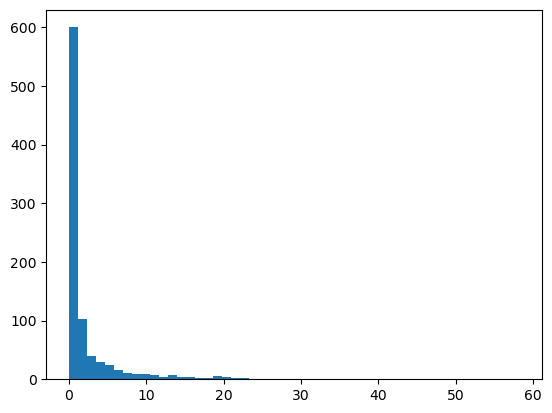

In [16]:
plt.hist(odds_titanic, bins=50);

$$log(odds) = log(\frac{p}{1-p})$$

Pero el log odds no es tan disperso, histograma del log odds

In [17]:
log_odds_titanic = np.log(odds_titanic)

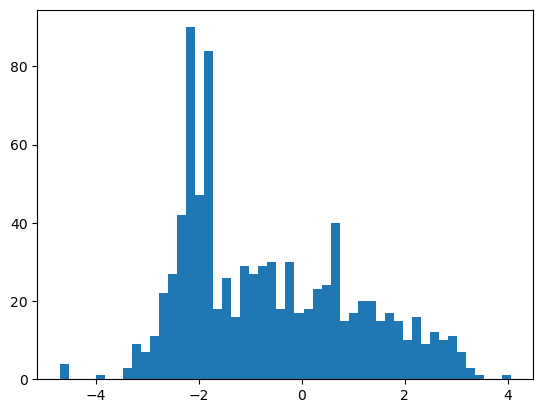

In [18]:
plt.hist(log_odds_titanic, bins=50);

### ¿Y esto que? 

Si tomamos los coeficientes de una regresión logistica como si gura una regresión lineal, obtenemos un numero extraño

$$z = \Theta ^T X $$



In [19]:
# Calcula Z
z = (model.coef_ * X).sum(axis=1) + model.intercept_

Resulta ser que z es lo mismo que log odds

In [20]:
verdad = pd.DataFrame({
    'z': z,
    'log_odds': log_odds_titanic
})
verdad.head()

,z,log_odds
0,-2.276357,-2.276357
1,2.243739,2.243739
2,0.432538,0.432538
3,1.839575,1.839575
4,-2.440047,-2.440047


In [21]:
coeficientes = pd.DataFrame({
    'features': X.columns,
    'coeficientes': model.coef_[0]
})
coeficientes

,features,coeficientes
0,Age,-0.036838
1,SibSp,-0.312666
2,Parch,-0.074817
3,Fare,0.003171
4,Pclass_2,-0.717232
5,Pclass_3,-1.907992
6,Sex_male,-2.541440
7,Embarked_Q,-0.074937
8,Embarked_S,-0.457017


la combinación de los coeficientes con las X, obtienes las log_odds de sobrevivir

### Esto es importante porque de aquí sale sigmoide

$$log(\frac{p}{1-p}) = \Theta ^T X$$


Aplicamos la exponencial en ambos lados:

$$
e^{\Theta ^T X} = \frac{p}{1 - p}
$$

Despejamos \( p \):

$$
p = \frac{e^{\Theta ^T X}}{1 + e^{\Theta ^T X}}
$$

Simplificando

$$
p= \frac{1}{1 + e^{\Theta ^T X}}
$$

Comprobando

### _Comprobamos que Sklearn opera conforme a la teoría_ 

### Comparando diferentes tipos de regresiones

#### Regresion logistica


In [22]:
target = 'Survived'

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = linear_model.LogisticRegression().fit(X_train, y_train)
probabilidades_modelo1 = model.predict_proba(X_test)[:, 1]

#### Checando los coeficientes

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

  #### Regresion logistica polinomial 2


In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo2 = pipeline.predict_proba(X_test)[:, 1]

#### Polinomio grado 3

In [26]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('logistic', linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)
probabilidades_modelo3 = pipeline.predict_proba(X_test)[:, 1]

#### Analisis del discriminante lineal 

In [27]:
from sklearn import discriminant_analysis

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)
probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]

### Junta los datasets

In [29]:
juntar = pd.DataFrame({
    'real': y_test,
    'logistica1': probabilidades_modelo1,
    'logistica2': probabilidades_modelo2,
    'logistica3': probabilidades_modelo3,
    'probabilidades_disc': probabilidades_modelo_disc
})
juntar

,real,logistica1,logistica2,logistica3,probabilidades_disc
495,0,0.154918,0.186737,2.131811e-01,0.094228
648,0,0.104608,0.124614,1.369802e-01,0.056745
278,0,0.076535,0.011373,2.245662e-07,0.066734
31,1,0.933821,0.993344,9.999965e-01,0.971403
255,1,0.691444,0.647217,9.840554e-01,0.741915
...,...,...,...,...,...
263,0,0.310728,0.398735,4.809887e-01,0.260234
718,0,0.169593,0.083595,7.957597e-02,0.097571
620,0,0.115896,0.295843,4.350125e-01,0.078247
786,1,0.720773,0.437105,6.214087e-01,0.769548


In [30]:
# Bins
bins = 5

juntar['bins_log1'] = pd.qcut(juntar['logistica1'], q = bins, labels=False) +1
juntar['bins_log2'] = pd.qcut(juntar['logistica2'], q = bins, labels=False) +1
juntar['bins_log3'] = pd.qcut(juntar['logistica3'], q = bins, labels=False) +1
juntar['bins_dist'] = pd.qcut(juntar['probabilidades_disc'], q = bins, labels=False) +1
# Agrupaciones
grouped_log1 = juntar.groupby('bins_log1').mean()
grouped_log2 = juntar.groupby('bins_log2').mean()
grouped_log3 = juntar.groupby('bins_log3').mean()
grouped_disc = juntar.groupby('bins_dist').mean()

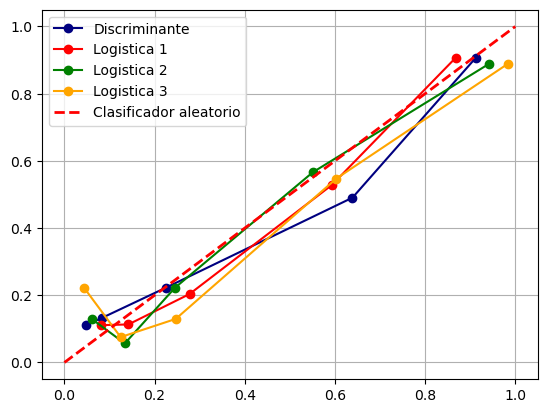

In [31]:
## Grafico de modelos
plt.plot(grouped_disc.probabilidades_disc, grouped_disc.real, color='navy', marker='o', label='Discriminante')
plt.plot(grouped_log1.logistica1, grouped_log1.real, color='red', marker='o', label='Logistica 1')
plt.plot(grouped_log2.logistica2, grouped_log2.real, color='green', marker='o', label='Logistica 2')
plt.plot(grouped_log3.logistica3, grouped_log3.real, color='orange', marker='o', label='Logistica 3')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
plt.grid()


¿Cuál es mejor? Veamos la función de perdida en el conjunto de prueba

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

In [32]:
from sklearn.metrics import log_loss

Modelo logistico

In [33]:
log_loss(y_pred=juntar.logistica1, y_true=juntar.real)

0.44386010907299145

Modelo polinomio 2

In [34]:
log_loss(y_pred=juntar.logistica2, y_true=juntar.real)

0.4350031665668785

Modelo polinomio 3

In [35]:
log_loss(y_pred=juntar.logistica3, y_true=juntar.real)

0.6811972324372253

Modelo discriminante

In [36]:
log_loss(y_pred=juntar.probabilidades_disc, y_true=juntar.real)


0.4469248818517997

buscas el log_loss más bajo

#### Histogramas

In [45]:
juntar[juntar.real == 1]['logistica1']

31     0.933821
255    0.691444
298    0.426326
609    0.906050
318    0.924594
         ...   
823    0.628306
573    0.734152
338    0.059570
261    0.050400
786    0.720773
Name: logistica1, Length: 100, dtype: float64

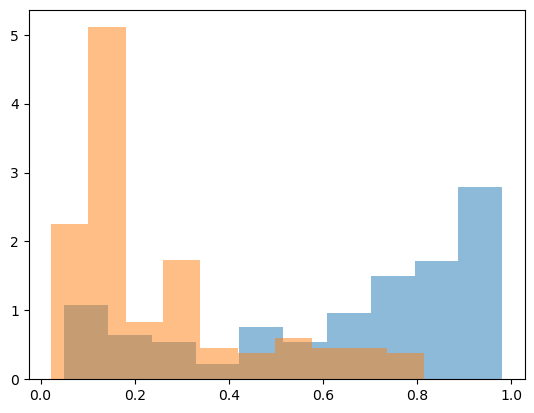

In [47]:
plt.hist(juntar[juntar.real == 1]['logistica1'], density=True, alpha=0.5)
plt.hist(juntar[juntar.real == 0]['logistica1'], density=True, alpha=0.5);

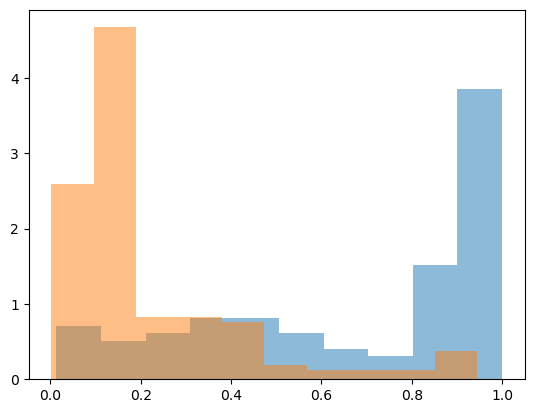

In [48]:
plt.hist(juntar[juntar.real == 1]['logistica2'], density=True, alpha=0.5)
plt.hist(juntar[juntar.real == 0]['logistica2'], density=True, alpha=0.5);

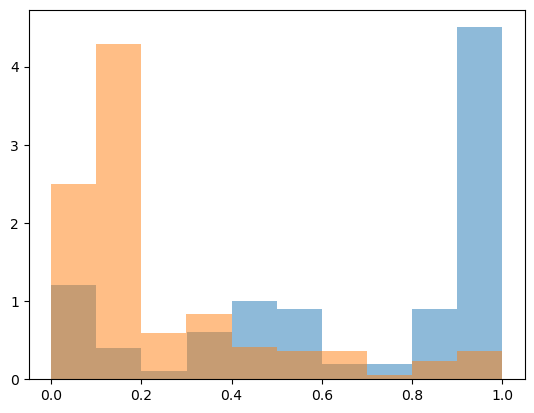

In [49]:
plt.hist(juntar[juntar.real == 1]['logistica3'], density=True, alpha=0.5)
plt.hist(juntar[juntar.real == 0]['logistica3'], density=True, alpha=0.5);

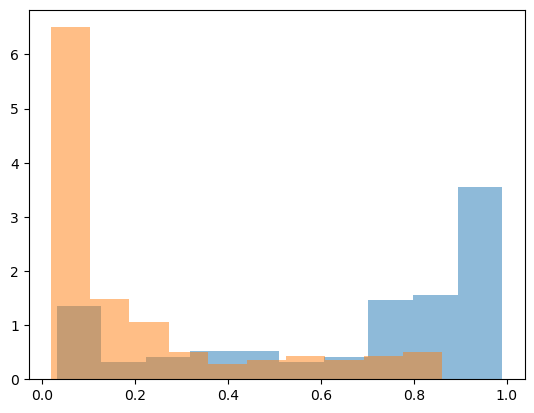

In [50]:
plt.hist(juntar[juntar.real == 1]['probabilidades_disc'], density=True, alpha=0.5)
plt.hist(juntar[juntar.real == 0]['probabilidades_disc'], density=True, alpha=0.5);